# UMAP chess dataset EDA

---

## 1. Staging

---

import section:

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import umap

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

import tqdm.notebook as tqn
import pdb

### 1.1 Project parametrisation

1. General parameters
2. Vectorized moves table
3. Metadata table

#### 1.1.1 General parameters

In [2]:
## project
notebook_ver = 0.3
## input dataset
data_pth = './data/games.csv'

#### 1.1.2 Vectorized moves table parameters

#### 1.1.3 Metadata table params

In [3]:
## Define nominal data variables to be thrown at one-hot-encoder
to_hot_encode = [
    'opening_eco',
    'increment_code',
    'victory_status'
]

## Define string variables for str vectorization
to_vectorize = [
    'white_id',
    'black_id'
]

## Define numerical cols to use
num_cols = [
    'winner_bin',
    'rated_bin',
    'game_len_mins',
#     'turns', # dense var
#     'white_rating', # dense var
#     'black_rating', # dense var
    'opening_ply'
]

### 1.2 Functions

In [76]:
def to_uni(mov):
    '''
    Turn str move encoding into a sequence of Unicode values
    '''
    move_unicode = []
    for char in str(mov):
        move_unicode.append(ord(char))
    return move_unicode

In [77]:
def encode_moves(moves_seq, encoding='unilog', magnitude=10_000_000):
    '''
    Encode move into an integer = 1*e^10
    '''
    moves = []

    for move in moves_seq.split(' '):
        ## Convert str encoding to unicode vals
        move_uni = to_uni(move)
        ## Multiply all unicode vals together
        move_prod = np.prod(np.array(move_uni))  
        
        if encoding == 'unilog':
            ## Take log2 for every move and multiply by 10_000_000
            moves.append(int(np.log2(move_prod)*magnitude))
        elif encoding == 'unicode':
            moves.append(int(move_prod))
        
            
    return(moves)

In [78]:
def move_vectorizer(moves_df, id_col='id'):
    """
    Takes long moves table and transposes it to wide format
    :return: list of pd.DataFrames 
    """
    
    transposed_moves = []
    
    ## Setup a tqn loop 
    for game in tqn.trange(0, len(moves_df.index.unique())):
        ## Slice source by game idx 
        GRABBED_MOVES = moves_df.loc[game] 
        ## Each column will correspond to a move number in the game sequence
        cols = range(1,len(GRABBED_MOVES)+1)
        
        ## Some games have only one move in that case pd.Series returns a single 'str' val
        ## instead of a list of strings. 
        if type(GRABBED_MOVES[id_col]) is str:
            game_id = GRABBED_MOVES[id_col]
            GRABBED_MOVES_TR = GRABBED_MOVES.iloc[0]
            ## Construct dataframe that represent game moves in a vector
            TRANS_MOVES = pd.DataFrame({1:GRABBED_MOVES_TR}, index=[game_id])
        else:
            game_id = GRABBED_MOVES[id_col].unique()[0]
            GRABBED_MOVES_TR = GRABBED_MOVES.drop(columns=id_col)
            ## Construct dataframe that represent game moves in a vector
            TRANS_MOVES = pd.DataFrame(GRABBED_MOVES_TR).T
            TRANS_MOVES.index = [game_id]
            TRANS_MOVES.columns = cols
        
        transposed_moves.append(TRANS_MOVES)
        
    return transposed_moves

### 1.3 Data load 

In [79]:
GAMES = pd.read_csv(data_pth)

## 2. Preprocessing & initial dataset exploration

---

In [80]:
## Encode binary variables to integers
GAMES['rated_bin'] = np.where(GAMES['rated'] == True, 1, 0)

GAMES.drop(columns='rated',
          inplace=True)

In [81]:
GAMES['winner_bin'] = np.where(GAMES['winner'] == 'white', 0, 1)

GAMES.drop(columns='winner',
          inplace=True)

In [82]:
## Opening, closing games dates transformation
GAMES['created_at_dt'] = pd.to_datetime(GAMES['created_at']/1000, unit='s', origin='unix')
GAMES['last_move_at_dt'] = pd.to_datetime(GAMES['last_move_at']/1000, unit='s', origin='unix')

GAMES['game_len_dt'] = GAMES['last_move_at_dt'] - GAMES['created_at_dt']
GAMES['game_len'] = GAMES['last_move_at'] - GAMES['created_at']

GAMES['game_len_mins'] = GAMES['game_len_dt'].dt.components['minutes']

## 3. Vector formation

---

### 3.1 Vectorized moves table

In [83]:
## create a algebraic notation to iccf notation board mapping
# iccf_board = [str(x)+str(y) for x in range(1,9) for y in range(1,9)]
# algebraic_board = [l + str(i) for l in list('abcdefgh') for i in range(1,9)]
# board_mapping = {algebraic : iccf for algebraic, iccf in zip(algebraic_board, iccf_board)}

In [84]:
## Encode moves into separate variable
GAMES['moves_encoded'] = GAMES['moves'].apply(lambda x: encode_moves(x, 
                                                                     magnitude=10, 
                                                                     encoding='unicode'))

In [85]:
## Create Moves Table
MOVES = GAMES[['moves_encoded','id']]
MOVES.reset_index(inplace=True, drop=True)

MOVES.head()

,moves_encoded,id
0,"[5200, 5300, 5148, 5346, 62964000, 5454, 65448...",TZJHLljE
1,"[5200, 416988, 5252, 5353, 5304, 5508, 6423600...",l1NXvwaE
2,"[5252, 5353, 5100, 5400, 339966, 5346, 333300,...",mIICvQHh
3,"[5200, 5300, 405756, 356796, 393822, 429624, 3...",kWKvrqYL
4,"[5252, 5353, 405756, 5400, 5200, 416988, 5300,...",9tXo1AUZ


In [86]:
## Form a vector out of moves_encoded variable
MOVES_EXPLODED = MOVES.explode(column='moves_encoded')

In [87]:
## Construct a list of dataframes representing vectorised games
transposed_moves = move_vectorizer(MOVES_EXPLODED)

  0%|          | 0/20058 [00:00<?, ?it/s]

In [88]:
## Concat all vectors into a single dataframe
MOVES_V = pd.concat(transposed_moves)
MOVES_V.fillna(0, inplace=True)

In [89]:
## Save table for later
MOVES_V.to_csv('./moves_trans.csv')

### 3.1 Vectorized moves table

In [90]:
## Instantiate One Hot Encoder
ohe = OneHotEncoder(handle_unknown='error')

In [91]:
## Instantiate Count Vectorizer
cve = CountVectorizer()

In [92]:
## Set column transformer
column_trans = make_column_transformer((ohe,to_hot_encode),
                                       remainder='passthrough')

In [93]:
## Fit column transformer
column_trans.fit(GAMES[to_hot_encode])

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['opening_eco', 'increment_code',
                                  'victory_status'])])

In [94]:
## Produce one-hot-encoded array 
hot_array = column_trans.transform(GAMES[to_hot_encode]).toarray()

HOT_ENCODED = pd.DataFrame(hot_array, 
                          columns = column_trans.get_feature_names())

/home/nef/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [95]:
## Form Meta game table
META = GAMES[num_cols].merge(HOT_ENCODED,
                     left_index=True,
                     right_index=True)

In [96]:
## Inspect META
META.head()

,winner_bin,rated_bin,game_len_mins,opening_ply,onehotencoder__x0_A00,onehotencoder__x0_A01,onehotencoder__x0_A02,onehotencoder__x0_A03,onehotencoder__x0_A04,onehotencoder__x0_A05,...,onehotencoder__x1_9+9,onehotencoder__x1_90+0,onehotencoder__x1_90+120,onehotencoder__x1_90+30,onehotencoder__x1_90+5,onehotencoder__x1_90+8,onehotencoder__x2_draw,onehotencoder__x2_mate,onehotencoder__x2_outoftime,onehotencoder__x2_resign
0,0,0,0,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,0,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,1,0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,1,0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1,0,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## UMAP model

---

Parameters:

In [97]:
distance_metric = 'cosine'
# metrics_available = euclidean, manhattan, chebyshev, minkowski, canberra, braycurtis, mahalanobis,
# wminkowski, seuclidean, cosine, correlation, haversine, hamming, jaccard, dice, russelrao, kulsinski,
# ll_dirichlet, hellinger, rogerstanimoto, sokalmichener, sokalsneath, yule

n_neighbors = 20
min_dist = 0.1

Instatiate & train the model:

In [98]:
## Instantiate UMAP model
reducer = umap.UMAP(metric=distance_metric,
                   n_neighbors=n_neighbors,
                   min_dist=min_dist,
                   n_epochs=500)

In [99]:
MOVES_V.index.rename('id',inplace=True)

In [100]:
MOVES_V.reset_index(drop=True, inplace=True)

In [101]:
MOVES_V.to_csv('./vec.csv')

In [102]:
## Train the model
embedding = reducer.fit_transform(MOVES_V)

/home/nef/anaconda3/lib/python3.8/site-packages/pynndescent/pynndescent_.py:891: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
/home/nef/anaconda3/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 2 has removed 0 edges.
It has only fully disconnected 196 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


In [122]:
EMBEDDING_DF = pd.DataFrame(embedding, columns=['x','y'])
EMBEDDING_DF = EMBEDDING_DF.fillna(0)

---

## Plot

---

Parameters:

In [131]:
## switches
cbar_switch = True

## display
alpha = 0.9
marker_shape = 'o'
marker_size = 4
dpi = 300

## data
cmap_variable = GAMES['turns']

## colors
facecolor = 'black'
labelcolor = 'white'
cmap = 'viridis'

Plot script:

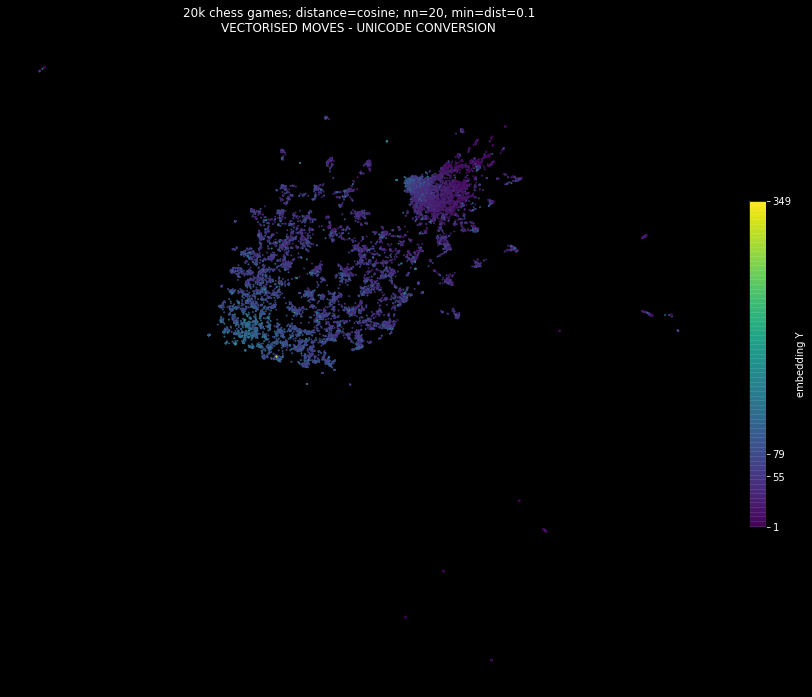

In [133]:
## Render vis
fig = plt.figure(figsize=(14,12))
fig.patch.set_facecolor(facecolor)

plot = plt.scatter(EMBEDDING_DF['x'], 
                EMBEDDING_DF['y'], 
                marker=marker_shape,
                s=marker_size,
                edgecolor='none',
                c=cmap_variable,
                cmap='viridis', 
                alpha=alpha)

plt.axis("off")
plt.title(f'20k chess games; distance={distance_metric}; nn={n_neighbors}, min=dist={min_dist}\nVECTORISED MOVES - UNICODE CONVERSION', 
          color='w')

if cbar_switch:
    cbar = plt.colorbar(fraction=0.05, 
                    shrink=0.5,
                    ticks=[cmap_variable.min(), 
                    np.quantile(cmap_variable,0.50),
                    np.quantile(cmap_variable,0.75),
                    cmap_variable.max()], alpha=alpha
                           )

    cbar.set_label('embedding Y', color=labelcolor)
    cbar.ax.yaxis.set_tick_params(color=labelcolor)
    cbar.solids.set_edgecolor("face")

plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=labelcolor)

_ = plot

plt.savefig(f"screens/{distance_metric}_nn{n_neighbors}_mind{min_dist}_v{notebook_ver}.png", 
            dpi=dpi, 
            facecolor=facecolor)